https://www.mathworks.com/help/signal/ug/walsh-hadamard-transform-for-spectral-analysis-and-compression-of-ecg-signals.html

# Kompresija EKG signala

EKG signali su veoma veliki i potrebno je da se čuvaju za analizu i neku buduću upotrebu. Hadamardova transformacija nudi dobro rešenje za ovaj problem jer pruža kompresiju koja zahteva manje memorijskog prostora. Ona takođe omogućava i brzu rekonstrukciju signala.

In [1]:
import numpy as np

In [2]:
import scipy
import scipy.signal as sig

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sympy import fwht
from sympy import ifwht

In [5]:
# rr time in seconds
rr = [1.0, 1.0, 0.5, 1.5, 1.0, 0.5, 1.5, 1.0]
# sampling rate
fs = 1024.0

# simulate a signal
pqrst = sig.wavelets.daub(10)
ecg = np.concatenate([sig.resample(pqrst, int(r * fs)) for r in rr])
t = np.arange(len(ecg)) / fs

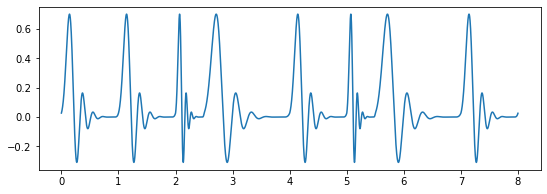

In [6]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg)
plt.show()

In [7]:
# add noise
ecg_with_noise = ecg + 0.05 * np.random.randn(1, len(ecg))[0]

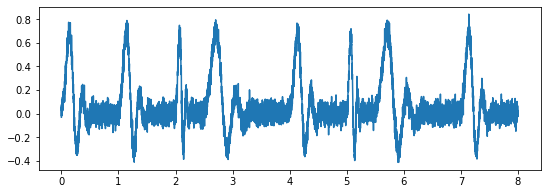

In [8]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise)
plt.show()

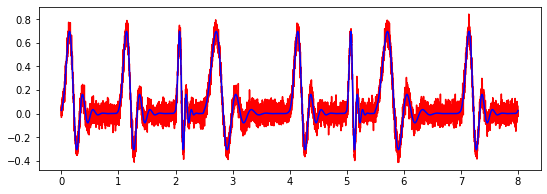

In [9]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg, color = 'b')
plt.show()

In [10]:
len(ecg_with_noise)

8192

In [11]:
y = fwht(ecg_with_noise)

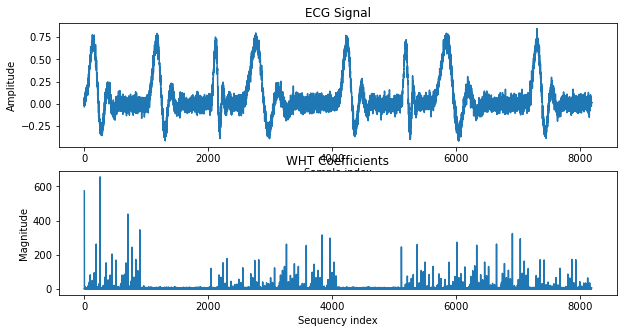

In [12]:
plt.figure(figsize = (10, 5))

plt.subplot(2,1,1)
plt.plot(ecg_with_noise)
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('ECG Signal')

plt.subplot(2,1,2)
plt.plot(np.abs(y))
plt.xlabel('Sequency index')
plt.ylabel('Magnitude')
plt.title('WHT Coefficients')

plt.show()

In [13]:
y_1 = np.append(y[:2000], np.zeros(len(y) - 2000))
ecg_reverse = ifwht(y_1);

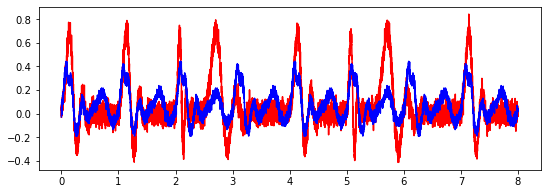

In [14]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [15]:
y_2 = np.append(y[:4200], np.zeros(len(y) - 4200))
ecg_reverse = ifwht(y_2);

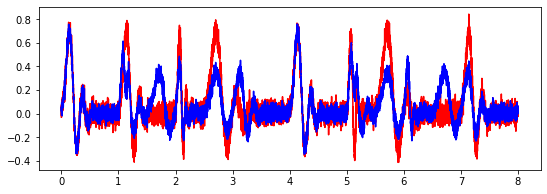

In [16]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [17]:
y_3 = np.append(y[:6000], np.zeros(len(y) - 6000))
ecg_reverse = ifwht(y_3);

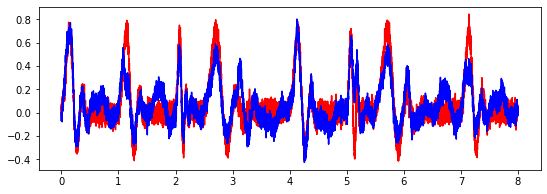

In [18]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [19]:
ecg_reverse = ifwht(y);

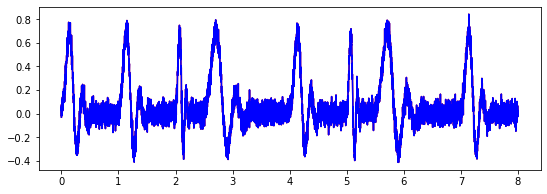

In [20]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

# Kompresija slike

In [21]:
from PIL import Image

In [22]:
from scipy.linalg import hadamard

In [23]:
import cv2

In [24]:
image = Image.open('Slike/slika.png')

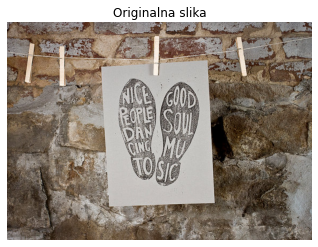

In [25]:
img = np.array(image)
plt.imshow(img)
plt.axis('off')
plt.title('Originalna slika')
plt.show()

In [26]:
image = image.convert('L')
image = image.resize((512, 512))

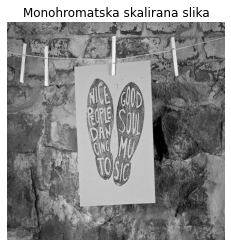

In [27]:
img = np.array(image)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Monohromatska skalirana slika')
plt.show()

In [28]:
img = img / 256

In [29]:
hademard = hadamard(512)
hademard_transform = np.dot(np.dot(hademard, img), hademard)
hademard_transform2 = hademard_transform / 512

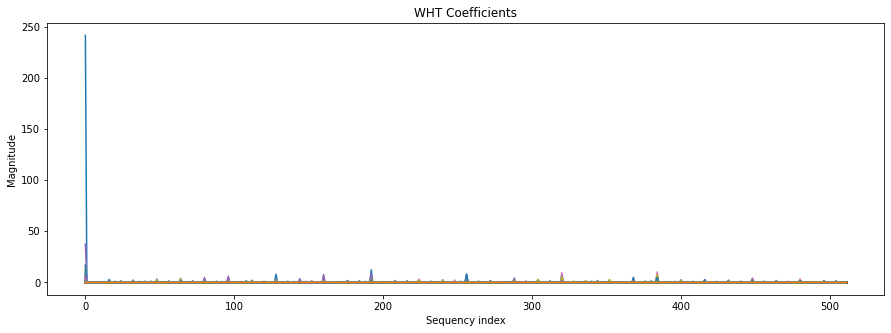

In [30]:
plt.figure(figsize=(15, 5))
plt.plot(np.abs(hademard_transform2))
plt.xlabel('Sequency index')
plt.ylabel('Magnitude')
plt.title('WHT Coefficients')

plt.show()

In [31]:
abs_hademard = np.abs(hademard_transform2)
hademard_compress = np.copy(hademard_transform2)
hademard_compress[abs_hademard < 0.1] = 0

In [ ]:
cv2.imshow('hada',hademard_compress)
cv2.waitKey(0)

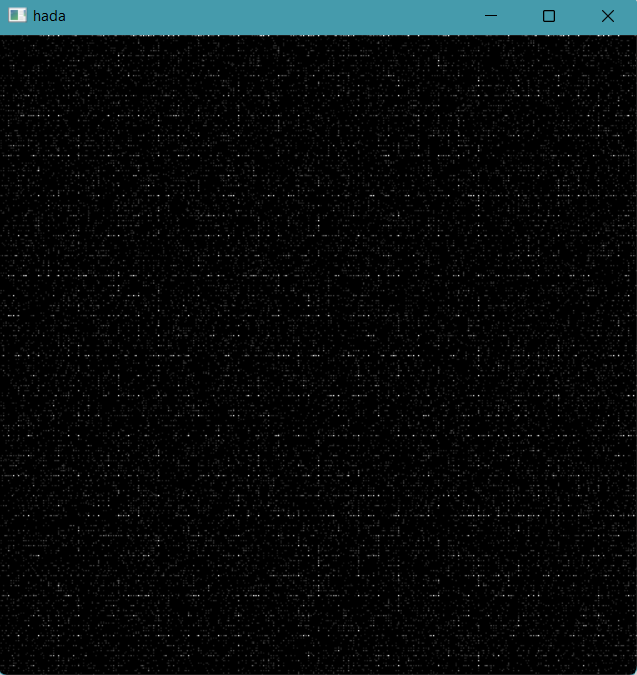

In [ ]:
Ihademard_transform = np.dot(np.dot(hademard, hademard_compress), hademard)

In [ ]:
Ihademard_transform2 = Ihademard_transform / 512

In [ ]:
cv2.imshow('hada',Ihademard_transform2)
cv2.waitKey(0)

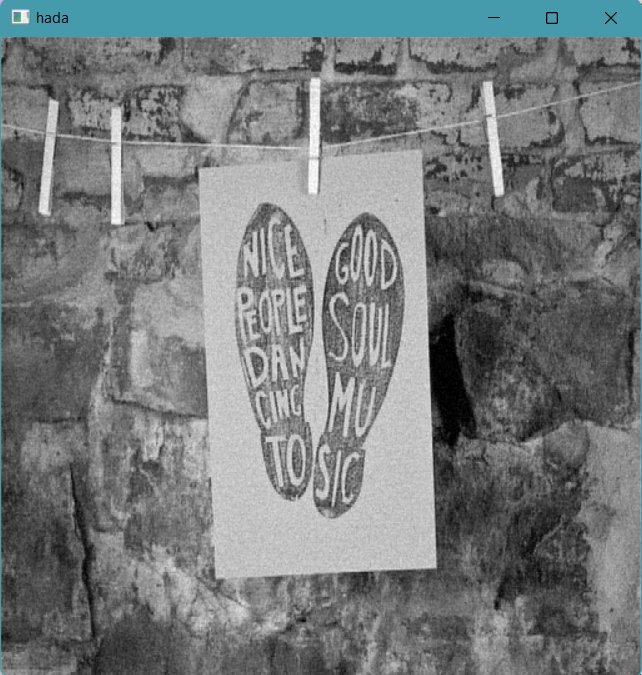